### ML acidoCEST
- Code source: [link](https://scikit-learn.org/0.15/auto_examples/plot_digits_pipe.html)
- Modified by Julio Cardenas-Rodriguez, Ph.D.
- CAMEL West @Tucson, AZ
- License: TBD

Change Log  
- 2018_06_04: Initial Version

### To -do list
- [ ] Add r-squared
- [ ] 4.3 and 5.5
- [ ] Compare against raw Z-spectra
- [ ] Compare against fitted Lorentzian for all samples
- [ ] Compare using a single calibration curve for linear regression



```python
yhat = p(x)                         # or [p(z) for z in x]
ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
results['determination'] = ssreg / sstot
```


In [68]:
molecules = ['Polymer',
             ' Monomer 2 (M2)',
             'Monomer 1 (M1)',
             'Iopamidol',
             'Gadolinium in 20mM Iopamidol']
n = 3

In [69]:
### Libraries
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
%matplotlib inline

import curve_fitting as cf
import imp
imp.reload(cf)

def center_ppm(xdata,Y):
    return xdata - xdata[np.argmax(1-Y)]
    

In [70]:
data_file ='../data/raw/CEST-ML-format_mdp_20181121_230pm_JCR_CJK_20190415.xlsx'


df         = pd.read_excel(data_file, sheetname= molecules[n])

In [71]:
info = df[['Sample ID', 'pH', 'concentration_mM','temperature_C', 'sat time_sec','sat power_uT']]
pH = info['pH'].copy()
print('Info shape \n',info.shape)
print('--'*10)
X = df.select_dtypes(include=['float64']).drop(['pH', 'sat time_sec',     'sat power_uT'],axis = 1)
print('X shape \n', X.shape )
print('--'*10)
for C in info.columns:  
    print(info[C].nunique(), C + ' unique values')
    print('--'*10)

Info shape 
 (585, 6)
--------------------
X shape 
 (585, 142)
--------------------
1 Sample ID unique values
--------------------
15 pH unique values
--------------------
7 concentration_mM unique values
--------------------
5 temperature_C unique values
--------------------
7 sat time_sec unique values
--------------------
6 sat power_uT unique values
--------------------


### Some spectra

In [72]:
info.iloc[0::60,:]

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT
0,Iopamidol,6.0,30,37,6.0,0.5
60,Iopamidol,6.0,30,37,6.0,4.0
120,Iopamidol,6.0,30,37,1.5,4.0
180,Iopamidol,6.0,30,37,6.0,4.0
240,Iopamidol,6.0,30,47,6.0,4.0
300,Iopamidol,6.0,15,37,6.0,4.0
360,Iopamidol,6.0,50,37,6.0,1.0
420,Iopamidol,6.0,50,37,0.5,4.0
480,Iopamidol,6.0,50,37,3.0,4.0
540,Iopamidol,6.0,50,32,6.0,4.0


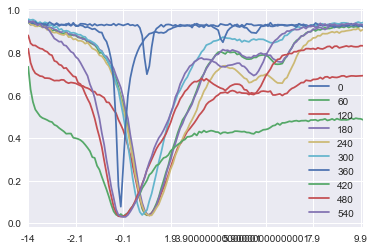

In [73]:
X.iloc[0::60,:].T.plot()

## Fitting Parameters

In [74]:
a1= .9
a2= .7
a3= .5
a4= .5

w1= 1
w2= 1
w3= 1
w4= 1

c1= 0
c2= 1
c3= 4.2
c4= 5.6

x0 = [a1,a2,a3,a4,   w1,w2,w3,w4,  c1,    c2,   c3,   c4,  1]
lb = [.1, 0,0,  0,   .1,.1,.1,.1,  c1-.1, .5,   c3-1, c4-.5,   -2]
ub = [1, .7,1,1,    3, 2, 2, 2,    c1+.1, 2.0 , c3+1, c4+.5, 2]  

d = pd.DataFrame(lb, columns=['lb'])
d['xo'] = x0
d['ub'] = ub

d.index = ['A1','A2','A3','A4','W1','W2','W3','W4','C1','C2','C3','C4','Scaling']
d

,lb,xo,ub
A1,0.1,0.9,1.0
A2,0.0,0.7,0.7
A3,0.0,0.5,1.0
A4,0.0,0.5,1.0
W1,0.1,1.0,3.0
W2,0.1,1.0,2.0
W3,0.1,1.0,2.0
W4,0.1,1.0,2.0
C1,-0.1,0.0,0.1
C2,0.5,1.0,2.0


### Test some of the fitting

Sample ID            NaN
pH                  6.75
concentration_mM      30
temperature_C         37
sat time_sec           6
sat power_uT         0.5
Name: 5, dtype: object


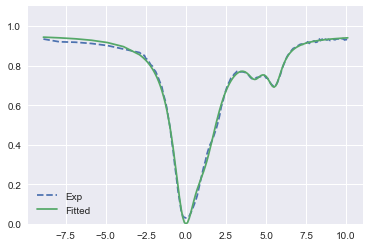

In [75]:
f = 5
s = 540


print(info.iloc[5,:])

y_data =  X.iloc[s,:].values[f::]
x_data =  center_ppm( X.columns.values[f::], y_data)

par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
yhat = cf.lorentzian(x_data,par_hat)

plt.figure()
plt.plot(x_data, y_data,'--')
plt.plot(x_data, 1-yhat,'-')
plt.legend(['Exp','Fitted'])
plt.ylim([0,1.1])
plt.show()



In [76]:
%%time
info = info.assign(Peak_4p2 = 1)
info = info.assign(Peak_5p6 = 1)
peak_01 = []
peak_02 = []
for s in range(X.shape[0]):
    y_data =  X.iloc[s,:].values[f::]
    x_data =  center_ppm( X.columns.values[f::], y_data)
    par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
    peak_01.append(par_hat[2])
    peak_02.append(par_hat[3])
    
    # peaks for ratiometric approach
    info.loc[s,'Peak_4p2'] = ( 1-(1-par_hat[2]) ) / (1-par_hat[2])   #par_hat[2]
    info.loc[s,'Peak_5p6'] = ( 1-(1-par_hat[3]) ) / (1-par_hat[3])   # par_hat[3]
    

CPU times: user 1min 6s, sys: 399 ms, total: 1min 6s
Wall time: 1min 7s


In [77]:
info['RATIO'] = np.log10( info['Peak_4p2'] / info['Peak_5p6'])

f1 = info.concentration_mM == 30
f2 = info.temperature_C == 37
f3 = info['sat time_sec'] == 6
f4 = info['sat power_uT'] ==3
d = info[f1&f2&f3&f4]

In [92]:
d

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT,Peak_4p2,Peak_5p6,RATIO
45,Iopamidol,6.00,30,37,6.0,3.0,0.077342,0.142377,-0.265024
46,NaN,6.15,30,37,6.0,3.0,0.104652,0.168066,-0.205731
47,NaN,6.30,30,37,6.0,3.0,0.146265,0.176628,-0.081921
48,NaN,6.45,30,37,6.0,3.0,0.214180,0.184572,0.064614
49,NaN,6.60,30,37,6.0,3.0,0.271126,0.149910,0.257342
50,NaN,6.75,30,37,6.0,3.0,0.345238,0.116184,0.472972
51,NaN,6.90,30,37,6.0,3.0,0.485333,0.068082,0.853005
52,NaN,7.00,30,37,6.0,3.0,0.457704,0.034537,1.122297
53,NaN,7.15,30,37,6.0,3.0,0.461719,0.011342,1.609688
54,NaN,7.30,30,37,6.0,3.0,0.371852,0.003381,2.041301


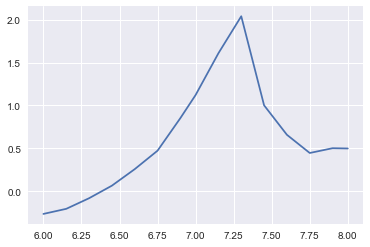

In [79]:
plt.plot(d.pH.values, d.RATIO.values)

In [80]:
import seaborn as sns

/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


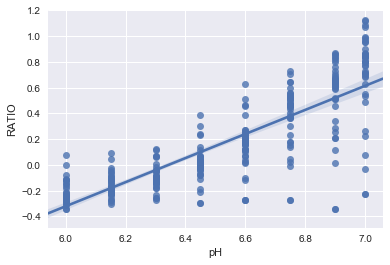

In [81]:
sns.regplot(x = 'pH', y ='RATIO', data = info[info.pH.values <= 7.0])

In [49]:
info.head(2)

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT,Peak_4p2,Peak_5p6,RATIO
0,Iopamidol,6.00,30,37,6.0,0.5,0.007799,0.014624,-0.273045
1,NaN,6.15,30,37,6.0,0.5,0.009530,0.017865,-0.272914


In [91]:
trainer

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT,Peak_4p2,Peak_5p6,RATIO
0,Iopamidol,6.00,30,37,6.0,3.0,0.007799,0.014624,-0.273045
1,NaN,6.15,30,37,6.0,3.0,0.009530,0.017865,-0.272914
2,NaN,6.30,30,37,6.0,3.0,0.010069,0.018333,-0.260262
3,NaN,6.45,30,37,6.0,3.0,0.009184,0.017994,-0.292074
4,NaN,6.60,30,37,6.0,3.0,0.009420,0.017560,-0.270491
5,NaN,6.75,30,37,6.0,3.0,0.009859,0.018414,-0.271317
6,NaN,6.90,30,37,6.0,3.0,0.008760,0.019221,-0.341293
7,NaN,7.00,30,37,6.0,3.0,0.011988,0.020083,-0.224077
8,NaN,7.15,30,37,6.0,3.0,0.007771,0.021623,-0.444459
9,NaN,7.30,30,37,6.0,3.0,0.010311,0.020035,-0.288506


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    0.4s finished


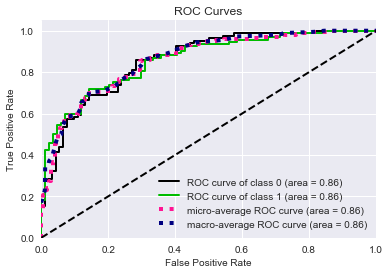

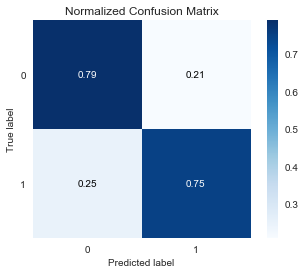

In [119]:
trainer = info[info['sat power_uT'] == 3.0]
v= ['Peak_4p2','Peak_5p6','sat time_sec','sat power_uT']
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression( info[v], info.pH,
                                                                           pH_cut_off = 6.8, n_cs=20 )

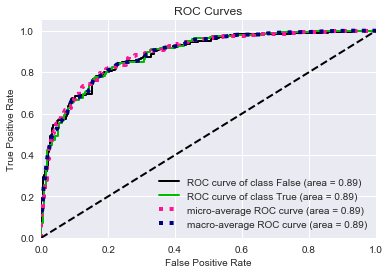

In [121]:
import scikitplot as skplt

v= ['Peak_4p2','Peak_5p6','sat time_sec','sat power_uT']
tester = info[info['sat power_uT'] != 3.0]
y_probas = clf_01.predict_proba(tester[v] )
skplt.metrics.plot_roc(tester.pH > 6.8, y_probas)

In [104]:
clf_01

LogisticRegression(C=1.623776739188721, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [105]:
np.exp(clf_01.coef_)

array([[1.16008392e+01, 4.16775189e-05]])

In [106]:
clf_01.coef_

array([[  2.45107744, -10.08554869]])

#### Logistic Regression

In [48]:
### define function to train model based on cuttoff for pH
def train_logistic_PCA_pipeline(Spectra, pH_observed, min_n=2, max_n= 10, pH_cut_off = 7.0, n_cs=20):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='liblinear', penalty='l1',max_iter=500,random_state=42)

    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)
    Cs = np.logspace(-3, 2, n_cs)
    
    param_grid ={
    'pca__n_components': num_pca_components,
    'logistic__C': Cs,
    'logistic__class_weight': ['balanced',None]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #Confusion
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True)
    plt.show()
    
    return estimator.best_estimator_, X_train, X_test, y_train, y_test

In [47]:
### define function to train model based on cuttoff for pH
def train_logistic_regression(Spectra, pH_observed, pH_cut_off = 7.0, n_cs=20):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='liblinear', penalty='l1',max_iter=500,random_state=42)

    # Training parameters
    Cs = np.logspace(-3, 2, n_cs)
    
    param_grid ={
    'C': np.logspace(-4, 4, n_cs),
    'class_weight': ['balanced',None]
    }
    
    
    estimator = GridSearchCV(logistic, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #Confusion
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True)
    plt.show()
    
    return estimator.best_estimator_, X_train, X_test, y_train, y_test

    # Grid Search on Pipeline
    estimator = GridSearchCV(logistic,
                         dict(
                              C= Cs,
                              class_weight= ['balanced',None],
                              fit_intercept= [True,False]), 
                             verbose = 1, cv = 3, n_jobs=3, iid = True)

Note on metrics
- precision = positive predictive value
- recall    = sensitivity

###  -training pH >7.0  

In [ ]:
(pH> 7).value_counts(normalize = True).round(2)

### Pipeline

In [ ]:
s = X.shape[1]
step_size = 1

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:step_size], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 7.0, n_cs=20 )

clf_01

### Only Logistic Regression

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression( X.iloc[:,0:s:step_size], pH,
                                                                           pH_cut_off = 7.0, n_cs=20 )

### pH > 6.8

In [ ]:
(pH > 6.8).value_counts(normalize = True).round(2)

In [ ]:
clf_pca, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:1], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 6.8, n_cs=20 )
clf_pca

For Mart

In [ ]:
pca = clf_pca.named_steps['pca']

In [ ]:
pca.transform(X.iloc[250:251,:])

In [ ]:
clf_pca.predict(X)